In [1]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [2]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"

In [3]:
import git
git = git.Git("../../../sonarqube/") 

# Goal

In this notebook we will analyse the jobs and builds associated to the tags via the commit difference with the previous tag. We will investigate what jobs and builds will be left out from the association and implement algorithms to refine our selection of jobs based on PRs and FixVersions

### Import builds and jobs

In [4]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)

In [5]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
0,241946101,241946099,2017-06-12 09:21:03+00:00,2017-06-12 09:13:51.063000+00:00,2017-06-12 09:21:43+00:00,25614.1,canceled,2018-06-02 14:51:19.734000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
1,241946103,241946099,2017-06-12 09:22:43+00:00,2017-06-12 09:13:51.107000+00:00,2017-06-12 09:21:43+00:00,25614.2,canceled,2018-06-02 14:51:19.764000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
2,241952024,241952022,2017-06-12 09:36:43+00:00,2017-06-12 09:32:52.227000+00:00,2017-06-12 09:37:23+00:00,25615.1,canceled,2018-06-02 14:51:25.661000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
3,241952025,241952022,NaT,2017-06-12 09:32:52.237000+00:00,2017-06-12 09:37:24+00:00,25615.2,canceled,2018-06-02 14:51:25.669000+00:00,464f5da96733c14818f4b4bfeb878951b859ee0c,70183628,SONAR-9304 Add comments to make tests clearer,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
4,241952045,241952044,2017-06-12 09:42:16+00:00,2017-06-12 09:32:59.994000+00:00,2017-06-12 09:53:48+00:00,25616.1,passed,2018-06-02 14:51:26.125000+00:00,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,70183633,SONAR-9304 Add comments to make tests clearer,refs/pull/2104/merge,https://github.com/SonarSource/sonarqube/pull/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136978,315411337,315411335,2017-12-12 15:23:15+00:00,2017-12-12 15:22:41.091000+00:00,2017-12-12 15:26:39+00:00,34811.2,passed,2018-06-03 16:57:36.971000+00:00,abd0650045b3fcc95ac8459a6fc2450a1bd889c0,93642638,SONAR-10134 Fix ITs on quality gates by settin...,refs/pull/2866/merge,https://github.com/SonarSource/sonarqube/pull/...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136980,315421140,315421138,2017-12-12 15:43:26+00:00,2017-12-12 15:42:34.682000+00:00,2017-12-12 15:44:25+00:00,34812.2,passed,2018-06-03 16:57:47.778000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136981,315421147,315421146,2017-12-12 15:43:25+00:00,2017-12-12 15:42:40.583000+00:00,2017-12-12 16:01:05+00:00,34813.1,passed,2018-06-03 16:57:47.837000+00:00,a5005e0ca38a67e7d70c255154990ed10be31020,93645838,SONAR-10187 Provide more options to populate e...,refs/pull/2895/merge,https://github.com/SonarSource/sonarqube/pull/...


### Pull Requests commits

In [6]:
pr_commits = pd.read_csv(f"{csv_folder}/pr_commits.csv", index_col=0)

### Import all tag comparisons dataset

In [7]:
compare_tags = pd.read_csv(f"{csv_folder}/compare_tags_sha.csv", index_col=0)
compare_tags.head(2)

,from_tag,from_date,from_sha,to_sha,ahead_by,behind_by,to_tag,to_date
0,8.4.2.36762,2020-08-27 14:11:31,2de1f343e3dbd9e88007b42e475512677c04eb8a,a0d372f704998d38856c26e28662fd7de062f873,0,4,8.4.1.35646,2020-07-14 08:13:18
1,8.4.0.35506,2020-07-03 07:09:27,74b4533439f380827d68e8c01667eeaecad89fc7,a0d372f704998d38856c26e28662fd7de062f873,6,0,8.4.1.35646,2020-07-14 08:13:18


### Import tags

In [8]:
alltags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
alltags.Date = pd.to_datetime(alltags.Date)
alltags.actual_release_date = pd.to_datetime(alltags.actual_release_date)
alltags["month"] = alltags.Date.dt.month
alltags["year"] = alltags.Date.dt.year
alltags.rename(columns={"Date":"release_date"}, inplace=True)
tags = alltags.tail(-1)
tags.head()

,actual_release_date,Tag,Sha,release_date,month,year,major_version,jira_version
1,NaT,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaT,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaT,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2
5,2015-11-26,5.2,f045be98be3ba032b6b19d71574038eeeb91803b,2015-11-02 08:56:19,11,2015,5,5.2


### Filter the ones after the project started using TravisCI

In [9]:
tags = tags[tags.release_date > "2015-03-10"]

In [10]:
tags.Tag.nunique()

56

### Import tag comparison pairs

In [11]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison

,from_author_date,to_author_date,from_tag,to_tag,ahead_by,behind_by,from_sha,to_sha,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days
0,2015-10-16 09:31:18,2016-04-08 13:44:39,4.5.6,4.5.7,7,0,12d931e5a31e1692a428bbb34ba11cd63aebf998,e2afb0bff1b8be759789d2c1bc9348de6f519f83,7,175 days 04:13:21,175.175938,2015-10-16 11:31:18,2016-04-08 15:44:39,175 days 04:13:21,175.175938
43,2015-04-02 08:09:45,2015-06-02 08:34:06,5.1,5.1.1,7,0,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,7,61 days 00:24:21,61.016910,2015-04-02 10:09:45,2015-06-02 10:34:06,61 days 00:24:21,61.016910
66,2015-06-02 08:34:06,2015-07-27 08:03:21,5.1.1,5.1.2,12,0,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,12,54 days 23:29:15,54.978646,2015-06-02 10:34:06,2015-07-27 10:03:21,54 days 23:29:15,54.978646
90,2015-07-27 08:03:21,2015-11-02 08:56:19,5.1.2,5.2,2853,0,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,f045be98be3ba032b6b19d71574038eeeb91803b,2853,98 days 00:52:58,98.036782,2015-07-27 10:03:21,2015-11-02 09:56:19,97 days 23:52:58,97.995116
115,2015-11-02 08:56:19,2016-01-08 10:09:15,5.2,5.3,561,0,f045be98be3ba032b6b19d71574038eeeb91803b,8db783e62b266eeb0d0b10dc050a7ca50e96c5d1,561,67 days 01:12:56,67.050648,2015-11-02 09:56:19,2016-01-08 11:09:15,67 days 01:12:56,67.050648
141,2016-01-08 10:09:15,2016-03-08 15:48:19,5.3,5.4,438,0,8db783e62b266eeb0d0b10dc050a7ca50e96c5d1,7b02df9be3cd9448699b5857586e1c6e2b28c007,438,60 days 05:39:04,60.235463,2016-01-08 11:09:15,2016-03-08 16:48:19,60 days 05:39:04,60.235463
168,2016-03-08 15:48:19,2016-05-02 14:09:29,5.4,5.5,725,0,7b02df9be3cd9448699b5857586e1c6e2b28c007,5773a4aab0ef6c0de79d3038e82f8a051049d6d0,725,54 days 22:21:10,54.931366,2016-03-08 16:48:19,2016-05-02 16:09:29,54 days 23:21:10,54.973032
196,2016-05-02 14:09:29,2016-06-01 11:59:09,5.5,5.6,349,0,5773a4aab0ef6c0de79d3038e82f8a051049d6d0,074f3d1169f9688d15af4aff67e7e672cbeed782,349,29 days 21:49:40,29.909491,2016-05-02 16:09:29,2016-06-01 13:59:09,29 days 21:49:40,29.909491
225,2016-06-01 11:59:09,2016-07-25 08:13:12,5.6,5.6.1,32,0,074f3d1169f9688d15af4aff67e7e672cbeed782,4f37a3f3b40da4bba953d1ed9a2b0d114869a8ad,32,53 days 20:14:03,53.843090,2016-06-01 13:59:09,2016-07-25 10:13:12,53 days 20:14:03,53.843090
255,2016-07-25 08:13:12,2016-09-19 14:34:40,5.6.1,5.6.2,25,0,4f37a3f3b40da4bba953d1ed9a2b0d114869a8ad,9c1c190107023ffca5f67d6d0184ff5371c5347f,25,56 days 06:21:28,56.264907,2016-07-25 10:13:12,2016-09-19 16:34:40,56 days 06:21:28,56.264907


### Import issues

In [12]:
issues = pd.read_csv(f"{csv_folder}/issues_community.csv", index_col=0)
for date_field in ["created", "duedate", "lastViewed", "resolutiondate", "updated"]:
    issues[date_field] = pd.to_datetime(issues[date_field], errors="coerce")
issues = issues[issues.created > '2015-03-17 15:04:32+0000']
issues.head()

,updated,environment,creator,issue_id,reporter,issuetype_name,issue_key,assignee,votes,created,project,resolutiondate,status_id,summary,reporter_name,resolution_name,lastViewed,issuetype_id,edition,duedate,status_name,votes_votes,description,priority_id,priority_name,status,assignee_name,creator_name,created_month,created_year
0,2020-09-29 08:54:53+00:00,NaN,Julien Lancelot,97898,Julien Lancelot,Task,SONAR-13913,NaN,0,2020-09-29 08:54:53+00:00,SONAR,NaT,1,Remove table clean up used in Integration Tests,julien.lancelot,NaN,NaT,3,Community,NaT,Open,0,- Remove org.sonar.server.platform.BackendClea...,3,Major,Open,NaN,julien.lancelot,9,2020
1,2020-09-28 10:18:24+00:00,NaN,Malena Ebert,97868,Malena Ebert,Task,SONAR-13912,Malena Ebert,0,2020-09-28 10:14:16+00:00,SONAR,NaT,1,Add OWASP Dependency Check task to Cirrus CI,malena.ebert,NaN,NaT,3,Community,NaT,Open,0,The goal of this task is to detect vulnerabili...,3,Major,Open,malena.ebert,malena.ebert,9,2020
3,2020-09-28 15:38:40+00:00,NaN,Jeremy Davis,97858,Jeremy Davis,New Feature,SONAR-13909,Julien Lancelot,0,2020-09-28 09:20:49+00:00,SONAR,NaT,10002,C# and VB.NET analysis updates,jeremy.davis,NaN,NaT,2,Community,2020-10-05 00:00:00+00:00,In Review,0,The C# analysis now improves complexity rules ...,3,Major,In Review,julien.lancelot,jeremy.davis,9,2020
4,2020-09-28 20:02:41+00:00,NaN,Jeremy Davis,97855,Jeremy Davis,Improvement,SONAR-13907,Julien Lancelot,0,2020-09-28 09:00:01+00:00,SONAR,NaT,10002,JavaScript/TypeScript analysis updates,jeremy.davis,NaN,NaT,4,Community,2020-10-05 00:00:00+00:00,In Review,0,The changes are:\r\n* a new rule to detect XXE...,3,Major,In Review,julien.lancelot,jeremy.davis,9,2020
5,2020-09-24 12:57:08+00:00,NaN,Mathieu Cutivel,97813,Mathieu Cutivel,Improvement,SONAR-13906,Mathieu Cutivel,0,2020-09-24 12:57:00+00:00,SONAR,NaT,3,Prevent ALM binding configuration modal from c...,mathieu.cutivel,NaN,NaT,4,Community,2020-10-01 00:00:00+00:00,In Progress,0,When clicking outside of the ALM configuration...,3,Major,In Progress,mathieu.cutivel,mathieu.cutivel,9,2020


In [13]:
issues.shape

(4478, 30)

### Import issue versions

In [14]:
versions = pd.read_csv(f"{csv_folder}/issues_versions.csv", index_col=0)
versions.head()

,issue_id,version_name,version_id
0,97777,8.4.2,16404
1,97773,8.4.2,16404
2,97525,8.4.2,16404
3,97521,8.4,15833
4,97347,8.4.2,16404


### Import issue fixversions

In [15]:
fix_versions = pd.read_csv(f"{csv_folder}/issues_fixversions.csv", index_col=0)
fix_versions.head()

,issue_id,fixVersion_name,fixVersion_id
0,97864,8.5,16342
1,97858,8.5,16342
2,97855,8.5,16342
3,97786,8.6,16435
4,97773,8.5,16342


### Import Pull request data

In [16]:
prs = pd.read_csv(f"{csv_folder}/prs.csv", index_col=0)
prs.created_at = pd.to_datetime(prs.created_at)
prs.closed_at = pd.to_datetime(prs.closed_at)

In [17]:
prs

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,2015,SONAR-9122 prevent setting a project as private,2017-05-03 12:26:16+00:00,2017-05-04 09:19:56+00:00,closed,True,e10f04d5b4055e2813ac01a811b325a414797c4e,b10cb50ec7c26a85dd549de6633e60705994bd66,master,13bb5a131e0fa2c20f041d4e8c79e847fc601348,feature/stas/lock-private-projects
1,2008,Upgrade scanner in performance tests,2017-05-02 19:17:44+00:00,2017-05-04 11:50:06+00:00,closed,False,492bb4ff488ee992a3708622ca9a6be88ee7f11a,7b2958e443c4c629f3e35aba7182d7cb524b250b,master,9a90c2f7097fab8fe94681b1e7ea09294a308314,feature/sb/sonar-runner-in-its
2,2026,SQ 6.4 web hardening 5,2017-05-04 15:17:16+00:00,2017-05-09 09:14:37+00:00,closed,True,ab64e97deecaf047d85debdd1ba669e1d4071d51,87d60ccc748d84f55f7c102b6ec6d489215eef8f,master,368935160f780caf8a9b7ff250606e84c68c50cb,feature/greg/6.4_web_hardening_5
3,2046,Hardening Wednesday,2017-05-10 11:54:28+00:00,2017-05-11 08:56:18+00:00,closed,False,041ee672ade0c77d75db0ca379bad255936d9730,7f939f50b63f7c6ac7aab6d8fbb71a06193df0be,master,285e16edf389aa34db2bc2f0ce99a2e3042f3f32,feature/tb/hardening-wednesday
4,2021,SONAR-6135 Upgrade MySQL driver to 5.1.42,2017-05-04 07:42:23+00:00,2017-05-04 12:52:45+00:00,closed,True,5e1fdd17e3147180e3a4273705835e2fc393ae20,6d18fa56e8782e022169738587750dfe59b4015a,master,da23d42a0af4db59d7aeac71dd51f659b43f763b,feature/eh/SONAR-6135
...,...,...,...,...,...,...,...,...,...,...,...
3244,610,SONAR-6919 Enforce some mandatory web service ...,2015-11-02 16:09:25+00:00,2015-11-05 14:52:07+00:00,closed,False,5da330ecc08721aca649a4a401e89149d267b42d,526e3b9053582e4921d705c35a4b24d3cd9d0d60,master,526e3b9053582e4921d705c35a4b24d3cd9d0d60,feature/ws_enforce_mandatory_fields
3245,620,SONAR-6922 Initial version of report viewer,2015-11-06 10:13:57+00:00,2015-11-09 07:40:54+00:00,closed,True,15f6f81f1ff387f387bca18342301a2e88877060,7567526369d1082a8023623c016b970cac314c64,master,eb5fd4fe77eb1b82b3aa5e1c3474d85ac39ee9ce,feature/report_viewer
3246,639,SONAR-7027 Add developer concept in CE,2015-11-18 14:03:35+00:00,2015-11-19 13:48:15+00:00,closed,True,a8ce34fd965d2ea0e212b3576666ee594459f8c5,30e7baee5a1785168c2e2c2bcea73ae1a78087da,master,240cf9f64ff0d7aa1e94f4fdeeb449f48141bcb0,feature/introduce_dev_in_ce
3247,602,SONAR-6834 Purge CE_ACTIVITY when deleting a p...,2015-10-27 10:31:24+00:00,2015-10-27 11:07:27+00:00,closed,False,68c6fe12c4df2678e1a0ca8d60afb300b0faba50,19350f7eb06f0f46674ad394e0919edbae2b2a2a,branch-5.2,8d809c371e9b00c1886b1f7e83d8699e546bdb0e,feature/delete_ce_activity_when_del_project


### Import tags commits difference

In [18]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits

,from_tag,to_tag,ahead_sha
0,4.5.6,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83
1,4.5.6,4.5.7,8cd20603bdbff2d725a3ba981839120b8d40faac
2,4.5.6,4.5.7,d0d9715a973793e5c8fc0ada606f70ffc7f08bf7
3,4.5.6,4.5.7,36d9a7959a95cbe44550e2c7790bf68d4c1066c8
4,4.5.6,4.5.7,75d7c7ff807aa0c081935fe8c93095277e6fe497
...,...,...,...
15600,8.4.0.35506,8.4.1.35646,08e36b12704d8ac30f56d3d5ecf73d5457424b5c
15601,8.4.1.35646,8.4.2.36762,2de1f343e3dbd9e88007b42e475512677c04eb8a
15602,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
15603,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


### Import quality metrics

In [44]:
sw_quality_metrics = pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)

In [45]:
tags_comparison_sw_metrics = tags_comparison.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag", how="left")

In [46]:
tags_comparison_sw_metrics = tags_comparison_sw_metrics.merge(sw_quality_metrics, left_on="jira_version", right_on="version_name", how="left")

In [93]:
#tags_comparison_sw_metrics.to_csv(f"{csv_folder}/tags_pairs_sw_metrics.csv")
tags_comparison_sw_metrics.drop(columns=["from_author_date", "to_author_date", "from_sha", "to_sha",\
                                        "from_commit_date", "to_commit_date", "Tag", "jira_version",\
                                        "diff_author_dates", "diff_commit_dates"]).loc[2:].shape

(52, 19)

## Start

### Count n of builds, jobs and merge requests per pair

In [71]:
data = [] 
merge_data = []
def get_n_jobs(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    for jobid in j.id:
        data.append((row.from_tag, row.to_tag, jobid))
    return len(j)

def get_n_merge_jobs(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    for jobid in j.id:
        data.append((row.from_tag, row.to_tag, jobid))
    return len(j[j.commitref.str.contains("merge").fillna(False)])

def get_n_builds(row):
    commits = tags_comparison_commits[(tags_comparison_commits.from_tag == row.from_tag) & \
                                      (tags_comparison_commits.to_tag == row.to_tag)].ahead_sha
    j = jobs[jobs.commitsha.isin(commits)]
    return len(builds[builds.id.isin(j.buildid)])

def get_n_pull_request_jobs(row):
    tags_comparison_commits_example = tags_comparison_commits[(tags_comparison_commits.from_tag==row.from_tag) \
                                    & (tags_comparison_commits.to_tag==row.to_tag)].ahead_sha

    #commits_pr = pr_commits[pr_commits.commitsha.isin(tags_comparison_commits_example)]
    pull_requests = prs[prs.head_sha.isin(tags_comparison_commits_example)]
    pull_requests = pull_requests.append(prs[prs.merge_commit_sha.isin(tags_comparison_commits_example)])
    
    df = []
    for i, pr_number in enumerate(pull_requests.pr_number.unique()):
        if i == 0:
            df = jobs[jobs.commitref.str.contains(f"pull/{pr_number}").fillna(False)]
        else:
            df = pd.concat([df, jobs[jobs.commitref.str.contains(f"pull/{pr_number}").fillna(False)]])           
    if(len(df)>0):
        for jobid in df.id:
            merge_data.append((row.from_tag, row.to_tag, jobid))
    return len(df)

In [72]:
tags_comparison["n_jobs"] = tags_comparison.apply(get_n_jobs, axis=1)
tags_comparison["n_builds"] = tags_comparison.apply(get_n_builds, axis=1)
tags_comparison["n_merge_jobs"] = tags_comparison.apply(get_n_merge_jobs, axis=1)

from :https://docs.travis-ci.com/user/pull-requests/#double-builds-on-pull-requests
* Rather than build the commits that have been pushed to the branch the pull request is from, we build the merge between the source branch and the upstream branch.

When only looking at the difference in commits between the two tags we may miss out on some pull request builds because Travis CI does not build the commits from the source branch (which are the commits we get as difference) but "fictive commits" which are the merge of the source and upstream branch.
Therefore in order to get a complete picture of the process of development of the release, we need to include these as well.

We do it by retrieving for each difference commit the pull request which match that commit in their head commit (the commit which is to be merged into the target branch) or in the merge_commit_sha. We noticed that Sonarqube does not use merge commits and therefore shas are kept when pull requests succeed. Once the list of pull requests is obtained, we query all the jobs which are associated with that pull request via its number.

In [73]:
tags_comparison["n_pull_request_jobs"] = tags_comparison.apply(get_n_pull_request_jobs, axis=1)

<AxesSubplot:xlabel='n_pull_request_jobs'>

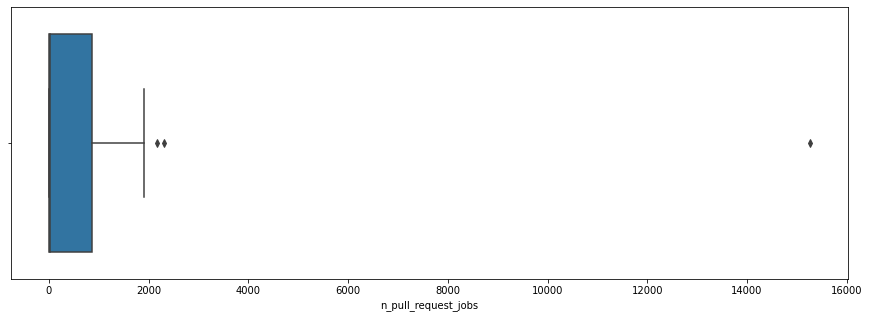

In [74]:
sns.boxplot(x=tags_comparison.n_pull_request_jobs)

In [75]:
tags_comparison[["from_tag", "to_tag", "ahead_by", "n_jobs","n_builds","n_merge_jobs","n_pull_request_jobs"]]

,from_tag,to_tag,ahead_by,n_jobs,n_builds,n_merge_jobs,n_pull_request_jobs
0,4.5.6,4.5.7,7,0,0,0,0
43,5.1,5.1.1,7,0,0,0,0
66,5.1.1,5.1.2,12,0,0,0,7
90,5.1.2,5.2,2853,10933,2031,23,15255
115,5.2,5.3,561,4852,511,0,2309
141,5.3,5.4,438,3879,431,0,1449
168,5.4,5.5,725,3873,552,0,1652
196,5.5,5.6,349,2478,354,0,1372
225,5.6,5.6.1,32,217,31,0,49
255,5.6.1,5.6.2,25,168,24,0,103


**Dataframes with job ids from difference commits and jobs ids from pull requests for each pair**

In [76]:
tags_jobs = pd.DataFrame(data, columns=["from_tag", "to_tag", "job_id"])

**How many jobs did we include**

In [154]:
len(set(tags_jobs.job_id)) / jobs.id.nunique()

0.26600381069183765

In [77]:
tags_merge_jobs = pd.DataFrame(merge_data, columns=["from_tag", "to_tag", "job_id"])

Do some jobs appear in both datasets?

In [78]:
tags_merge_jobs[tags_merge_jobs.job_id.isin(tags_jobs.job_id)]

,from_tag,to_tag,job_id


**Do some pull request appear in more than one pair?**

In [79]:
x = tags_merge_jobs.groupby("job_id").from_tag.count()
len(x[x>1])

5755

In [80]:
len(x)

30398

Yes, we have 5755 job ids from pull requests which repeat. We investigate why.

In [81]:
job_id = x[x>1].index[0]
jobs[jobs.id == job_id]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
63575,153329639,153329638,2016-08-18 16:38:40+00:00,2016-08-18 16:38:16.530000+00:00,2016-08-18 16:59:14+00:00,12485.1,passed,2018-05-31 06:48:17.734000+00:00,3b6712add9f13559c1d35f06fadf6fe7ede01ff3,43555978,SONAR-6846 support duplicate snapshots with is...,refs/pull/1152/merge,https://github.com/SonarSource/sonarqube/pull/...


In [82]:
tags_merge_jobs[tags_merge_jobs.job_id == job_id]

,from_tag,to_tag,job_id
22093,5.6.1,5.6.2,153329639
24465,6.0,6.1,153329639


In [83]:
prs[prs.pr_number == 1152]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
176,1152,SONAR-6846 support duplicate snapshots with is...,2016-08-18 16:38:12+00:00,2016-08-22 16:14:58+00:00,closed,True,d94aa825004f0c8666690da143d466d71b31388d,54e5d34f816386987a5ccd0634e311d692a64588,branch-5.6,d94aa825004f0c8666690da143d466d71b31388d,feature/sl/SONAR-6846/support_duplicate_snapsh...


Looks like it is a new feature which was introduced both in a old version and cherry picked in the upcoming one
* We accept that some builds may affect more than one pair. The way we created pairs is that they are matched with the most similar version (ideally the one it was branched from). This does not prevent developers from cherry picking changes from other branches or fixes to other tags. This would still be considered a change from the previous tag.

### Analyse the type of pull requests for each pair

In [32]:
data = []
def pull_requests_analysis(row):
    if row.name == 873:
        return
    tags_comparison_commits_example = tags_comparison_commits[(tags_comparison_commits.from_tag==row.from_tag) \
                                    & (tags_comparison_commits.to_tag==row.to_tag)].ahead_sha

    commits_pr = pr_commits[pr_commits.commitsha.isin\
           (tags_comparison_commits_example)]
    
    #pull_requests = prs[prs.pr_number.isin(commits_pr.pr_number)]
    pull_requests = prs[(prs.merge_commit_sha.isin(tags_comparison_commits_example))\
                       | (prs.head_sha.isin(tags_comparison_commits_example))]
    
    pr_merged_in_master = 0
    pr_merged_in_feature_branch = 0
    pr_merged_from_master = 0
    pr_merged_from_feature_branch = 0
    branches_to_analyse = []
    print("-"*20)
    print(f"{row.from_tag}->{row.to_tag}")
    for i, pr in pull_requests.iterrows():
        added = False
        #base
        if("master" == pr.base_ref):
            pr_merged_in_master+=1
        else:
            branches_to_analyse.append((pr.values))
            added=True
            pr_merged_in_feature_branch+=1
        #head
        if("master" == pr.head_ref):
            pr_merged_from_master+=1
        else:
            if(not added):
                branches_to_analyse.append((pr.values))
            pr_merged_from_feature_branch+=1
    
    print(f"pr_merged_in_master: {pr_merged_in_master}")
    print(f"pr_merged_in_feature_branch: {pr_merged_in_feature_branch}")
    print(f"pr_merged_from_master: {pr_merged_from_master}")
    print(f"pr_merged_from_feature_branch: {pr_merged_from_feature_branch}")
            
    for branch in branches_to_analyse:
        values = [row.from_tag, row.to_tag] + list(branch)
        data.append(tuple(values))
        #print(f"{branch[0]}, sha {branch[1][:6]}, {branch[2]}, sha {branch[3][:6]} has number jobs:", len(jobs[jobs.commitref==f"refs/heads/{branch[0]}"]))

In [33]:
x = tags_comparison.iloc[:-2]
x.apply(pull_requests_analysis, axis=1)

--------------------
4.5.6->4.5.7
pr_merged_in_master: 0
pr_merged_in_feature_branch: 0
pr_merged_from_master: 0
pr_merged_from_feature_branch: 0
--------------------
5.1->5.1.1
pr_merged_in_master: 0
pr_merged_in_feature_branch: 0
pr_merged_from_master: 0
pr_merged_from_feature_branch: 0
--------------------
5.1.1->5.1.2
pr_merged_in_master: 0
pr_merged_in_feature_branch: 2
pr_merged_from_master: 0
pr_merged_from_feature_branch: 2
--------------------
5.1.2->5.2
pr_merged_in_master: 247
pr_merged_in_feature_branch: 21
pr_merged_from_master: 1
pr_merged_from_feature_branch: 267
--------------------
5.2->5.3
pr_merged_in_master: 62
pr_merged_in_feature_branch: 5
pr_merged_from_master: 0
pr_merged_from_feature_branch: 67
--------------------
5.3->5.4
pr_merged_in_master: 43
pr_merged_in_feature_branch: 5
pr_merged_from_master: 0
pr_merged_from_feature_branch: 48
--------------------
5.4->5.5
pr_merged_in_master: 53
pr_merged_in_feature_branch: 11
pr_merged_from_master: 0
pr_merged_from_f

0       None
43      None
66      None
90      None
115     None
141     None
168     None
196     None
225     None
255     None
261     None
286     None
318     None
351     None
385     None
420     None
493     None
531     None
570     None
609     None
648     None
687     None
726     None
765     None
804     None
843     None
882     None
921     None
927     None
960     None
999     None
1038    None
1077    None
1116    None
1194    None
1233    None
1271    None
1308    None
1344    None
1379    None
1413    None
1446    None
1478    None
1509    None
1512    None
1539    None
1568    None
1623    None
1649    None
1674    None
1698    None
1699    None
dtype: object

In [34]:
merged_branch = pd.DataFrame(data, columns=["from_tag", "to_tag"] + list(prs.columns))

In [84]:
merged_branch

,from_tag,to_tag,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,5.1.1,5.1.2,403,SONAR-6673 Do not try to load DefaultNotificat...,2015-06-30 08:03:17+00:00,2015-07-13 14:13:03+00:00,closed,True,04c2c726849f317cd65bd93c20b3fb21ff7df900,5b63bfea88114285b46b884a25eee517b96d2b70,branch-5.1,5a0253f2dea14767fc9db008b6ffc4bb77a8c273,feature/fix_notif_manager_preview
1,5.1.1,5.1.2,425,SONAR-6700 fix undeleted computation working d...,2015-07-20 14:47:34+00:00,2015-07-21 09:54:23+00:00,closed,False,1949aa798fd3fb397584287de4896955b832f3a7,d7a4e565629a7c096239813aaa44245c819993a6,branch-5.1,d7a4e565629a7c096239813aaa44245c819993a6,feature/SONAR-6700_in_5.1
2,5.1.2,5.2,475,Feature/cache issues mode,2015-08-12 12:27:34+00:00,2015-08-12 15:01:44+00:00,closed,True,f0bc180f277abeae0c299db83ccd66839749f2c4,f14a07796a04815dabde6f357de3ac87e5344d4a,master,91c3bee035b2fe4249dca9f953f1a4b0e1b5474a,feature/cache_issues_mode
3,5.1.2,5.2,479,Feature/views in5.2,2015-08-24 06:59:22+00:00,2015-08-24 12:05:06+00:00,closed,False,059e000155de7e384b9872b11d20d4df01b8b5b5,2bfefbed900d10ee2320630c83f13d21346a1bb8,master,2bfefbed900d10ee2320630c83f13d21346a1bb8,feature/views_in5.2
4,5.1.2,5.2,499,support for views component persistence,2015-09-08 09:53:06+00:00,2015-09-09 07:33:16+00:00,closed,True,6c76ac7a87934c15dda9f746fc61f6e0694578b5,2c5b2483c87134537a88e057c5d2d588cc0b4f99,master,b3101c1575b89000737c854abf87631f1ec22a6f,feature/views_component_persistence
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,7.5,7.6,3193,"sonarqube task exec fail , no detail log",2019-01-03 09:32:19+00:00,2019-01-03 09:51:33+00:00,closed,False,NaN,15a5219cf8d4ef07b0fac1232fe40c74dbd73459,branch-5.6,138171d657c57fe015c4dcc4be996973f87f5365,master
1855,7.6,7.7,3196,SONAR-11680 upgrade Tomcat to 8.5.37,2019-02-07 12:56:13+00:00,2019-02-07 16:08:20+00:00,closed,True,1d12ea0bec9843400ec62e378df0730834220545,d2f6a51f791ab430da08bea7dc46373288274ffb,master,43730b44f13fc5dd93173bfafbdd1796c839dbdb,feature/sb/SONAR-11680
1856,7.6,7.7,3187,Data coming from Cobertura report cannot be an...,2018-11-16 11:33:30+00:00,2019-02-07 16:35:26+00:00,closed,False,2197c17928310ff03183910ffd3e763b3971cec1,824c80f0ab2fd9e8e9359e0816575fb80416ec92,branch-7.0,8b7cd93d7a751fd49e8df3faef1cf03e320f470a,master
1857,7.9,8.0,3227,use stopInfo() instead of stopDebug(),2019-09-30 02:46:49+00:00,2019-09-30 19:56:49+00:00,closed,True,9a40a5174209cd6642c667714cc86781c7650609,213ac5101c72969e70fd1f781d63dd57e4e72793,master,916be10a0908a05ad31dca327b9d315604f815c1,patch-1


In [85]:
merged_branch[(merged_branch.from_tag == "5.1.2") & (merged_branch.to_tag == "5.2") & (merged_branch.pr_number == 330)]

,from_tag,to_tag,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
159,5.1.2,5.2,330,SONAR-6578 WS api/metrics/types list all metri...,2015-05-26 13:48:47+00:00,2015-05-26 14:25:55+00:00,closed,True,349ffa2da19d8eb746d2e2a04fc9ff63331d7924,4f185c32600ace13c281243d17a591fd90c69081,master,47a0226e8e3032cf9e9777a12cda89bef63bc854,feature/server/ws_metrics_types


In [86]:
x = merged_branch.groupby(["head_ref", "head_sha"]).to_tag.count().reset_index()

In [87]:
x[x.to_tag > 1]

,head_ref,head_sha,to_tag
571,feature/jl/5.6_SONAR-8144,3fcc98a73d6afb99388e39f46272909a6d6600b2,2
600,feature/jl/SONAR-10246/fix_sso_groups_doc,862fc685698fffbfcefc24c466e606556130c03c,2
659,feature/jl/fix_add_project_to_qprofile,a56e60d168802ff9dc23ffec978bb412fd501f97,2
893,feature/sb/5.6/test-index,6f621785d7218218432a641e2cbf460763c768f8,2
1051,feature/sl/SONAR-10215/branch-6.7/fix_ISE_in_d...,0a1dc2146dd4b142d044c0f85634869410666ed3,2
1058,feature/sl/SONAR-10410/rule_system_tags_not_po...,72f64c95fdef18ec950d341c1a9093f30087e1c1,2
1065,feature/sl/SONAR-6846/support_duplicate_snapsh...,d94aa825004f0c8666690da143d466d71b31388d,2
1100,feature/sl/SONAR-7884/update_center_url_HTTPS,1389151511b840fc40929913a6abd7942f93740c,2
1102,feature/sl/SONAR-7896/fix_ISE_in_file_move_det...,a79dddadd5038e9d6bbc26d363e39576180c1063,2
1119,feature/sl/SONAR-8148/bullet_proof_FeedFileSou...,82c88c710622c568d91246e2e82cbe4e7be88128,2


**How many pull requests associated with pairs?**

In [88]:
len(merged_branch)

1859

**Investigate a pull request associated with more than 1 pair**

In [89]:
merged_branch[merged_branch.head_ref=="feature/jl/5.6_SONAR-8144"]

,from_tag,to_tag,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
596,5.6.2,5.6.3,1286,SONAR-8144 Not possible to set rule parameter ...,2016-10-03 06:40:58+00:00,2016-10-03 10:04:40+00:00,closed,True,3fcc98a73d6afb99388e39f46272909a6d6600b2,c89efd188daf9a0b54faa64bec9d8a514b5e0928,branch-5.6,3fcc98a73d6afb99388e39f46272909a6d6600b2,feature/jl/5.6_SONAR-8144
768,6.1.1,6.2,1286,SONAR-8144 Not possible to set rule parameter ...,2016-10-03 06:40:58+00:00,2016-10-03 10:04:40+00:00,closed,True,3fcc98a73d6afb99388e39f46272909a6d6600b2,c89efd188daf9a0b54faa64bec9d8a514b5e0928,branch-5.6,3fcc98a73d6afb99388e39f46272909a6d6600b2,feature/jl/5.6_SONAR-8144


In [90]:
commit1 = tags_comparison_commits[(tags_comparison_commits.from_tag=="5.6.2") \
                                    & (tags_comparison_commits.to_tag=="5.6.3")]

In [91]:
commit2 = tags_comparison_commits[(tags_comparison_commits.from_tag=="6.1.1") \
                                    & (tags_comparison_commits.to_tag=="6.2")]

In [92]:
set(commit1.ahead_sha).intersection(set(commit2.ahead_sha))

{'216f01bc94a205e57bb837ad239e7f20d9409976',
 '3fcc98a73d6afb99388e39f46272909a6d6600b2',
 '6f621785d7218218432a641e2cbf460763c768f8',
 'a68d912046cfbbe3f9d1493ab53414face1adae2',
 'c89efd188daf9a0b54faa64bec9d8a514b5e0928'}

This confirms that not all pairs have empty intersection. This is okay. Some changes are developed as fix or feature for a version and included into the upcoming one.

**How many jobs do we leave out?**

In [94]:
len(set(tags_merge_jobs.job_id).union(set(tags_jobs.job_id))) / jobs.id.nunique()

0.48791455874086564

In [95]:
jout = jobs[~jobs.id.isin(set(tags_merge_jobs.job_id).union(set(tags_jobs.job_id)))]

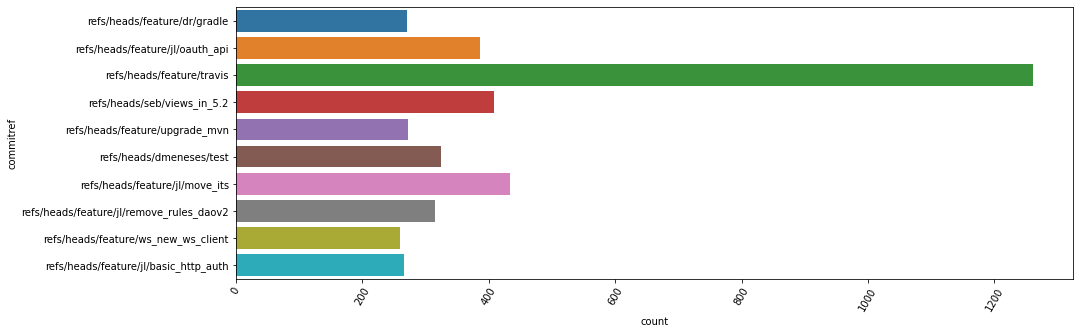

In [96]:
top_commitrefs = jout.commitref.value_counts().sort_values(ascending=False)
ax = sns.countplot(y=jout[jout.commitref.isin(top_commitrefs.head(10).index.tolist())].commitref)
ax.tick_params(axis='x', labelrotation= 60)

In [158]:
jout.commitref.str.contains("refs/heads/feature/").sum() / len(jout)

0.6191392470014752

**Include jobs on the head branch of the merge requests before the pr was closed**

In [52]:
jout[jout.commitref==top_commitrefs.index.tolist()[10]]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
8538,115057576,115057575,2016-03-10 13:39:07+00:00,2016-03-10 13:29:20.106000+00:00,2016-03-10 13:52:56+00:00,8706.1,passed,2018-05-30 04:32:57.651000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8539,115057577,115057575,2016-03-10 13:40:05+00:00,2016-03-10 13:29:20.127000+00:00,2016-03-10 13:53:42+00:00,8706.2,passed,2018-05-30 04:32:57.661000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8540,115057578,115057575,2016-03-10 13:43:37+00:00,2016-03-10 13:29:20.143000+00:00,2016-03-10 13:56:58+00:00,8706.3,passed,2018-05-30 04:32:57.671000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8541,115057579,115057575,2016-03-10 13:44:35+00:00,2016-03-10 13:29:20.156000+00:00,2016-03-10 13:59:28+00:00,8706.4,passed,2018-05-30 04:32:57.694000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8542,115057580,115057575,2016-03-10 13:45:09+00:00,2016-03-10 13:29:20.191000+00:00,2016-03-10 13:56:42+00:00,8706.5,passed,2018-05-30 04:32:57.704000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8543,115057581,115057575,2016-03-10 13:47:51+00:00,2016-03-10 13:29:20.204000+00:00,2016-03-10 13:53:52+00:00,8706.6,passed,2018-05-30 04:32:57.722000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8544,115057582,115057575,2016-03-10 13:48:39+00:00,2016-03-10 13:29:20.235000+00:00,2016-03-10 13:50:05+00:00,8706.7,passed,2018-05-30 04:32:57.732000+00:00,925d9deb38518b800a5dce956314851b8cb968b7,32512806,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8608,115078878,115078877,2016-03-10 14:59:28+00:00,2016-03-10 14:58:27.211000+00:00,2016-03-10 15:11:29+00:00,8716.1,passed,2018-05-30 04:33:27.779000+00:00,ee130183615cc7913674774cee963e41be85ca44,32518779,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8609,115078879,115078877,2016-03-10 15:02:29+00:00,2016-03-10 14:58:27.224000+00:00,2016-03-10 15:17:42+00:00,8716.2,passed,2018-05-30 04:33:27.796000+00:00,ee130183615cc7913674774cee963e41be85ca44,32518779,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...
8610,115078880,115078877,2016-03-10 15:02:28+00:00,2016-03-10 14:58:27.237000+00:00,2016-03-10 15:15:43+00:00,8716.3,passed,2018-05-30 04:33:27.817000+00:00,ee130183615cc7913674774cee963e41be85ca44,32518779,SONAR-7435 CE process waiting for WebServer to...,refs/heads/feature/sl/ce_jvm_process,https://github.com/SonarSource/sonarqube/compa...


In [53]:
t = tags_jobs[(tags_jobs.from_tag == "5.1.2") & (tags_jobs.to_tag == "5.2")]
tm = tags_merge_jobs[(tags_merge_jobs.from_tag == "5.1.2") & (tags_merge_jobs.to_tag == "5.2")]
commitmessages = list(t.merge(jobs[["id","commitmessage"]], left_on="job_id", right_on="id").commitmessage.unique())
commitmessages.append(list(tm.merge(jobs[["id","commitmessage"]], left_on="job_id", right_on="id").commitmessage.unique()))

In [54]:
jout[jout.commitmessage.isin(commitmessages)]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
140,242345037,242345036,2017-06-13 09:25:17+00:00,2017-06-13 09:24:16.776000+00:00,2017-06-13 09:38:03+00:00,25684.1,passed,2018-06-02 14:59:26.826000+00:00,a0b052bfb239d27fc277b7deffa47f8328661d69,70301449,fix quality flaws,refs/heads/feature/jl/fix_quality_flaws,https://github.com/SonarSource/sonarqube/commi...
141,242345038,242345036,2017-06-13 09:25:18+00:00,2017-06-13 09:24:16.783000+00:00,2017-06-13 09:30:09+00:00,25684.2,passed,2018-06-02 14:59:26.832000+00:00,a0b052bfb239d27fc277b7deffa47f8328661d69,70301449,fix quality flaws,refs/heads/feature/jl/fix_quality_flaws,https://github.com/SonarSource/sonarqube/commi...
448,64094999,64094998,2015-05-26 13:49:04+00:00,2015-05-26 13:48:22.182000+00:00,2015-05-26 14:03:29+00:00,1504.1,passed,2018-05-29 05:33:36.617000+00:00,eb020b298da9577db53ac18f740dd7b6f445a680,18315764,SONAR-6578 WS api/metrics/types list all metri...,refs/heads/feature/server/ws_metrics_types,https://github.com/SonarSource/sonarqube/compa...
453,64098826,64098825,2015-05-26 14:15:03+00:00,2015-05-26 14:14:37.928000+00:00,2015-05-26 14:18:17+00:00,1509.1,failed,2018-05-29 05:33:39.074000+00:00,9035e9087caf506b5dffa4f1e9e760b22b0c3851,18316902,SONAR-6576 WS api/metrics/domains list all the...,refs/heads/feature/server/ws_metric_domains,https://github.com/SonarSource/sonarqube/compa...
482,64214516,64214515,2015-05-27 08:01:19+00:00,2015-05-27 08:01:07.349000+00:00,2015-05-27 08:16:20+00:00,1538.1,passed,2018-05-29 05:35:34.316000+00:00,e0317ff4d936b8cbfe2a19f980ad91da91af3f27,18349503,SONAR-6589 Apply feedback from PR,refs/heads/feature/server/ce_clean_project_con...,https://github.com/SonarSource/sonarqube/compa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135128,190958442,190958439,2017-01-11 13:51:46+00:00,2017-01-11 13:51:45.541000+00:00,2017-01-11 13:55:59+00:00,16719.2,passed,2018-06-01 19:56:30.249000+00:00,a043923e7f1d8655fd280eb1fc39ce885ba4b6b4,54559583,Fix quality flaws,refs/pull/1520/merge,https://github.com/SonarSource/sonarqube/pull/...
136083,178867397,178867396,2016-11-25 15:17:47+00:00,2016-11-25 15:17:41.984000+00:00,2016-11-25 15:43:36+00:00,15427.1,passed,2018-06-01 15:19:33.109000+00:00,ea7f366390b1333e890cb9f9e2a5b08c9b4f58c9,51042065,fix quality flaws,refs/pull/1406/merge,https://github.com/SonarSource/sonarqube/pull/...
136084,178867400,178867396,2016-11-25 15:17:43+00:00,2016-11-25 15:17:42.032000+00:00,2016-11-25 15:20:19+00:00,15427.2,passed,2018-06-01 15:19:33.158000+00:00,ea7f366390b1333e890cb9f9e2a5b08c9b4f58c9,51042065,fix quality flaws,refs/pull/1406/merge,https://github.com/SonarSource/sonarqube/pull/...
136085,178867405,178867404,2016-11-25 15:18:18+00:00,2016-11-25 15:17:42.399000+00:00,2016-11-25 15:44:11+00:00,15428.1,passed,2018-06-01 15:19:33.365000+00:00,0f24c0bdfc5501314c85c0b18bac5c63cac6829a,51042064,fix quality flaws,refs/heads/feature/stas/for-6.3,https://github.com/SonarSource/sonarqube/compa...


In [55]:
merged_branch

,from_tag,to_tag,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,5.1.1,5.1.2,403,SONAR-6673 Do not try to load DefaultNotificat...,2015-06-30 08:03:17+00:00,2015-07-13 14:13:03+00:00,closed,True,04c2c726849f317cd65bd93c20b3fb21ff7df900,5b63bfea88114285b46b884a25eee517b96d2b70,branch-5.1,5a0253f2dea14767fc9db008b6ffc4bb77a8c273,feature/fix_notif_manager_preview
1,5.1.1,5.1.2,425,SONAR-6700 fix undeleted computation working d...,2015-07-20 14:47:34+00:00,2015-07-21 09:54:23+00:00,closed,False,1949aa798fd3fb397584287de4896955b832f3a7,d7a4e565629a7c096239813aaa44245c819993a6,branch-5.1,d7a4e565629a7c096239813aaa44245c819993a6,feature/SONAR-6700_in_5.1
2,5.1.2,5.2,475,Feature/cache issues mode,2015-08-12 12:27:34+00:00,2015-08-12 15:01:44+00:00,closed,True,f0bc180f277abeae0c299db83ccd66839749f2c4,f14a07796a04815dabde6f357de3ac87e5344d4a,master,91c3bee035b2fe4249dca9f953f1a4b0e1b5474a,feature/cache_issues_mode
3,5.1.2,5.2,479,Feature/views in5.2,2015-08-24 06:59:22+00:00,2015-08-24 12:05:06+00:00,closed,False,059e000155de7e384b9872b11d20d4df01b8b5b5,2bfefbed900d10ee2320630c83f13d21346a1bb8,master,2bfefbed900d10ee2320630c83f13d21346a1bb8,feature/views_in5.2
4,5.1.2,5.2,499,support for views component persistence,2015-09-08 09:53:06+00:00,2015-09-09 07:33:16+00:00,closed,True,6c76ac7a87934c15dda9f746fc61f6e0694578b5,2c5b2483c87134537a88e057c5d2d588cc0b4f99,master,b3101c1575b89000737c854abf87631f1ec22a6f,feature/views_component_persistence
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,7.5,7.6,3193,"sonarqube task exec fail , no detail log",2019-01-03 09:32:19+00:00,2019-01-03 09:51:33+00:00,closed,False,NaN,15a5219cf8d4ef07b0fac1232fe40c74dbd73459,branch-5.6,138171d657c57fe015c4dcc4be996973f87f5365,master
1855,7.6,7.7,3196,SONAR-11680 upgrade Tomcat to 8.5.37,2019-02-07 12:56:13+00:00,2019-02-07 16:08:20+00:00,closed,True,1d12ea0bec9843400ec62e378df0730834220545,d2f6a51f791ab430da08bea7dc46373288274ffb,master,43730b44f13fc5dd93173bfafbdd1796c839dbdb,feature/sb/SONAR-11680
1856,7.6,7.7,3187,Data coming from Cobertura report cannot be an...,2018-11-16 11:33:30+00:00,2019-02-07 16:35:26+00:00,closed,False,2197c17928310ff03183910ffd3e763b3971cec1,824c80f0ab2fd9e8e9359e0816575fb80416ec92,branch-7.0,8b7cd93d7a751fd49e8df3faef1cf03e320f470a,master
1857,7.9,8.0,3227,use stopInfo() instead of stopDebug(),2019-09-30 02:46:49+00:00,2019-09-30 19:56:49+00:00,closed,True,9a40a5174209cd6642c667714cc86781c7650609,213ac5101c72969e70fd1f781d63dd57e4e72793,master,916be10a0908a05ad31dca327b9d315604f815c1,patch-1


In [56]:
x = merged_branch[(merged_branch.from_tag == "5.1.2") & (merged_branch.to_tag == "5.2")][["pr_number", "closed_at","head_ref"]]
x

,pr_number,closed_at,head_ref
2,475,2015-08-12 15:01:44+00:00,feature/cache_issues_mode
3,479,2015-08-24 12:05:06+00:00,feature/views_in5.2
4,499,2015-09-09 07:33:16+00:00,feature/views_component_persistence
5,462,2015-08-05 11:56:45+00:00,jh_fix_quality
6,496,2015-09-07 14:40:52+00:00,feature/custom_measures_for_views
7,464,2015-08-06 12:26:52+00:00,feature/views_in_5.2
8,460,2015-08-07 12:25:53+00:00,feature/ce_measure_api
9,491,2015-09-04 16:07:08+00:00,feature/ws_search_templates
10,495,2015-09-07 14:54:31+00:00,feature/api_annotated_checks
11,459,2015-08-06 07:11:11+00:00,feature/ws-permissions-users


In [57]:
y = x.loc[2]
y

pr_number                          475
closed_at    2015-08-12 15:01:44+00:00
head_ref     feature/cache_issues_mode
Name: 2, dtype: object

In [58]:
y.closed_at

Timestamp('2015-08-12 15:01:44+0000', tz='UTC')

In [97]:
def get_associated_jobs_before_pr(merged_branch):    
    job_ids_prs = []
    data = []
    for i, row in merged_branch.iterrows():
            job_ids_prs = jobs[(jobs.commitref==f"refs/heads/{row.head_ref}") & (jobs.created_at < row.closed_at)].id.values.tolist()
            for job_id in job_ids_prs:
                data.append((row.from_tag, row.to_tag, job_id))
    return data

In [98]:
data = get_associated_jobs_before_pr(merged_branch)
associated_branch_pr_jobs = pd.DataFrame(data, columns=["from_tag", "to_tag", "job_id"])
associated_branch_pr_jobs

,from_tag,to_tag,job_id
0,5.1.1,5.1.2,71779386
1,5.1.1,5.1.2,71779388
2,5.1.1,5.1.2,71779389
3,5.1.1,5.1.2,71779390
4,5.1.1,5.1.2,71779391
...,...,...,...
105153,7.9.3,7.9.4,666504443
105154,7.9.3,7.9.4,666960186
105155,7.9.3,7.9.4,666960187
105156,7.9.3,7.9.4,667861343


**How many jobs do we leave out?**

In [99]:
len(set(tags_merge_jobs.job_id).union(set(tags_jobs.job_id)).union(associated_branch_pr_jobs.job_id)) / jobs.id.nunique()

0.7062993218136557

In [62]:
jobs[~jobs.id.isin(set(tags_merge_jobs.job_id).union(set(tags_jobs.job_id)).union(associated_branch_pr_jobs.job_id))]

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
6,241955853,241955852,2017-06-12 09:50:40+00:00,2017-06-12 09:45:48.061000+00:00,2017-06-12 09:56:41+00:00,25617.1,failed,2018-06-02 14:51:52.446000+00:00,00e86fd06991a1e54e3b17eb82f2532f85de6489,70184755,SONAR-9356 skipOnboardingTutorial updates user...,refs/heads/feature/jl/onboarding,https://github.com/SonarSource/sonarqube/compa...
7,241955856,241955852,2017-06-12 09:50:43+00:00,2017-06-12 09:45:48.109000+00:00,2017-06-12 09:54:52+00:00,25617.2,passed,2018-06-02 14:51:52.512000+00:00,00e86fd06991a1e54e3b17eb82f2532f85de6489,70184755,SONAR-9356 skipOnboardingTutorial updates user...,refs/heads/feature/jl/onboarding,https://github.com/SonarSource/sonarqube/compa...
8,241956722,241956721,2017-06-12 09:50:27+00:00,2017-06-12 09:48:49.511000+00:00,2017-06-12 09:51:07+00:00,25618.1,canceled,2018-06-02 14:51:47.140000+00:00,b34d8845506f0de01138e525d118fe292d204334,70185018,SONAR-9363 Create a step to choose the technology,refs/heads/feature/stas/onboarding/tutorial,https://github.com/SonarSource/sonarqube/compa...
9,241956723,241956721,2017-06-12 09:50:43+00:00,2017-06-12 09:48:49.525000+00:00,2017-06-12 09:51:07+00:00,25618.2,canceled,2018-06-02 14:51:47.157000+00:00,b34d8845506f0de01138e525d118fe292d204334,70185018,SONAR-9363 Create a step to choose the technology,refs/heads/feature/stas/onboarding/tutorial,https://github.com/SonarSource/sonarqube/compa...
10,241956742,241956741,2017-06-12 09:50:26+00:00,2017-06-12 09:48:54.652000+00:00,2017-06-12 10:01:41+00:00,25619.1,passed,2018-06-02 14:51:48.061000+00:00,0110c87fd42c510bb2c2f7a274d654a9fb07fb29,70185025,SONAR-9363 Create a step to choose the technology,refs/pull/2137/merge,https://github.com/SonarSource/sonarqube/pull/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136964,315384153,315384150,2017-12-12 14:25:31+00:00,2017-12-12 14:24:59.944000+00:00,2017-12-12 14:26:29+00:00,34804.2,passed,2018-06-03 16:56:59.981000+00:00,461a3e73bcbf17463b96e6ed512349a747e39942,93633511,SONAR-10117 add test on error handling in Live...,refs/heads/feature/SONAR-10117/live-measures,https://github.com/SonarSource/sonarqube/compa...
136967,315394000,315393999,2017-12-12 14:46:23+00:00,2017-12-12 14:45:53.280000+00:00,2017-12-12 14:48:14+00:00,34806.1,passed,2018-06-03 16:57:05.148000+00:00,19d40345c690140eed20a9a20edae58e40747f3e,93636741,Fix unit test,refs/heads/feature/jl/SONAR-10134/reactivate_its,https://github.com/SonarSource/sonarqube/compa...
136968,315394001,315393999,2017-12-12 14:46:24+00:00,2017-12-12 14:45:53.296000+00:00,2017-12-12 14:47:29+00:00,34806.2,passed,2018-06-03 16:57:05.164000+00:00,19d40345c690140eed20a9a20edae58e40747f3e,93636741,Fix unit test,refs/heads/feature/jl/SONAR-10134/reactivate_its,https://github.com/SonarSource/sonarqube/compa...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...


In [63]:
tags_comparison_commits[tags_comparison_commits.ahead_sha == "e10f04d5b4055e2813ac01a811b325a414797c4e"]

,from_tag,to_tag,ahead_sha
8015,6.3.2,6.4,e10f04d5b4055e2813ac01a811b325a414797c4e


In [64]:
prs[prs.pr_number==2015]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
0,2015,SONAR-9122 prevent setting a project as private,2017-05-03 12:26:16+00:00,2017-05-04 09:19:56+00:00,closed,True,e10f04d5b4055e2813ac01a811b325a414797c4e,b10cb50ec7c26a85dd549de6633e60705994bd66,master,13bb5a131e0fa2c20f041d4e8c79e847fc601348,feature/stas/lock-private-projects


### Investigate PRs left out

In [100]:
prs_out = prs[(~prs.pr_number.isin(merged_branch.pr_number.unique()))\
              & (prs.created_at > pd.to_datetime("2015-03-15 00:00:00+00:00"))]

In [159]:
prs_out.merged.value_counts(normalize=True)

False    0.710796
True     0.289204
Name: merged, dtype: float64

<AxesSubplot:xlabel='merged', ylabel='count'>

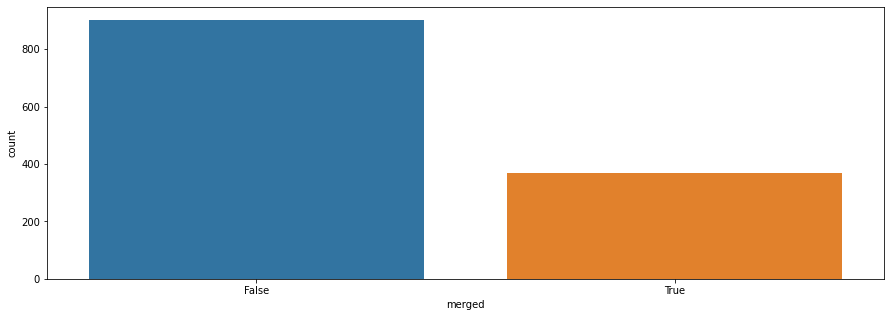

In [101]:
sns.countplot(x=prs_out.merged)

**Prs merged into master**

More likely to be detected by our approach

In [161]:
len(prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]) / len(prs_out[(prs_out.merged==True)])

0.9863760217983651

In [102]:
prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref == "master")]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
182,1194,Update UI welcome message,2016-08-30 14:54:51+00:00,2016-09-01 07:48:15+00:00,closed,True,c45240202ff2ab61b6ea5e17ccfd53a34413d983,ef892610fe2888078e33b5fd95d9220bd62e3c03,master,423cba9e6c64edb3b3416ff2278fe2b6ce29edc3,master
444,3184,Corrected typo,2018-10-09 22:44:50+00:00,2018-10-15 18:50:28+00:00,closed,True,ed414e9ab4b47257bcf4e4462ee097dd4a2eb18a,a6e127b39f864078041f71552d51767f9bb374a5,master,e1f95b2763e52f72fbe855f170518a8621679f7e,patch-1
1469,1843,Typos fix in the file warning msgs.,2017-03-23 12:37:35+00:00,2017-03-23 14:20:06+00:00,closed,True,817bb7c618063c4d6c7c260258ad77ccc7313d33,fa2a913859fd48bf63246d566b5fec250fb4aca8,master,dae292315711063f9bc9a5ee7f78a050bc8bf114,master
1874,333,Fixed typo,2015-05-27 09:04:39+00:00,2015-05-27 12:00:48+00:00,closed,True,b6cfe139c8d80d7c142813404296e6fa18e35dcc,b24b0f142fd8b43e3c5ee7fefbcfae16e354d319,master,b57ee37dd982fd4acdf550d8ceda9af45e516a91,master
2328,1218,SONAR-8033 Gravatar now works with non-lowerca...,2016-09-07 01:13:06+00:00,2016-09-09 15:46:50+00:00,closed,True,dedec549bf0440f9f6e849b7d46be2e9c2309a5e,c1e3840edf6c7fd36a3149b280a3d276ebce03a5,master,a813f8162a970c8e41a479dbcc56323f1602415b,master


Indeed these left out pull requests look like they are merged into other master branches of other projects

**PRs not merged into master**

In [103]:
prs_out[(prs_out.merged==True) & \
    (prs_out.base_ref != "master")]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
250,2212,MMF-870 Apply feedbacks,2017-07-03 08:15:16+00:00,2017-07-03 10:25:30+00:00,closed,True,165ea2c44bb481c63fbb69e62eeaabe2b13ee380,9e5686fa47dc38b116020ec99b557432ac0b8600,feature/lambda/enhance_project_activity,1f66e0d73d7bbb106e0ff70af073f40f562ed7de,feature/greg/enhance_project_activity_feedback
255,2205,SONAR-9482 Display the number of 'Sonar way' r...,2017-06-29 11:52:38+00:00,2017-06-30 08:40:35+00:00,closed,True,0b8163856d3af6b0f99f60b8c84074daebe52e2d,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,feature/lambda/highlight_sonar_way_profile,92e8201451a7007d36c201a3a4d7056f07ef5191,feature/lambda/implement_qp_show_ws
260,2207,"SONAR-9483 Compare a profile with a ""Sonar way...",2017-06-30 08:44:13+00:00,2017-06-30 11:05:02+00:00,closed,True,601e89c0f429c7437360a3bcf96400c1314fdf8b,0b8163856d3af6b0f99f60b8c84074daebe52e2d,feature/lambda/highlight_sonar_way_profile,81e6304cb1d7b6b435e06d86ef7d6ababf1fb86a,feature/lambda/add_compare_to_in_rules_search
261,2226,SONAR-9403 Add custom graph to the project act...,2017-07-07 11:03:36+00:00,2017-07-11 09:13:08+00:00,closed,True,74c53b85629ef84e572a6c9a94cc2f52019c024a,784299357d62cfb87b1885bf3bb87dbc2ed3144d,feature/lambda/understand-history-project,5de233dc7d54131c7dc9d73ac664295da4c10bec,feature/greg/custom-graph-history-project
265,2206,Highlight sonar way quality profiles,2017-06-29 12:15:12+00:00,2017-06-30 06:34:51+00:00,closed,True,b3cae67139df544ec8ef3d3e9cbaf9f48546c17a,7497736b259aafd0457411343ec14993d3566a17,feature/lambda/highlight_sonar_way_profile,574e458f3601afc69c57045b03d1ccde566261c2,feature/greg/highlight_sonar_way_profile
267,2220,SONAR-9418 Add activity interaction,2017-07-05 15:01:50+00:00,2017-07-05 16:05:43+00:00,closed,True,8b48c420723ed51405ec3ed1ccd4b6b7a991e856,7bd9f008ca0d9bf1b5b6cb75d10ba0ce0dd281d1,feature/lambda/understand-history-project,9198a555bee1f96a06736d7ca568a84ad7a376a7,feature/greg/project_activity_interaction
269,2223,SONAR-9508 Create api/ce/worker_count WS,2017-07-06 08:21:33+00:00,2017-07-06 09:34:17+00:00,closed,True,1cd3c185bffd49a44c96f434a3d016893771ada1,fd6a1b6a1c24564077d7bf8d2595b6d470bc9aa5,feature/platform/move_worker_count_to_gov,b823e5205efcdef8214e0174693bd9e02c1ba596,feature/jl/create_worker_count_ws
275,2217,SONAR-9507 ce worker count as internal property,2017-07-04 16:23:24+00:00,2017-07-06 08:16:38+00:00,closed,True,b940617d5719963c8337886d13afe1b34fb2461b,2e3eb0e482ff93b5c30189eca126a58e45e9221a,feature/platform/move_worker_count_to_gov,b940617d5719963c8337886d13afe1b34fb2461b,feature/sl/SONAR-9507/ce_worker_count_as_inter...
277,2231,SONAR-9525 dynamic ce workers,2017-07-10 09:17:31+00:00,2017-07-11 15:06:59+00:00,closed,True,aba4c66e9a547a2b45fc26dced52014b948f95f4,7da4f278af130240bdab1e5b5729e4e9c0296a59,feature/platform/move_worker_count_to_gov,aba4c66e9a547a2b45fc26dced52014b948f95f4,feature/sl/SONAR-9525/dynamic_ce_workers
284,2225,SONAR-9508 Display worker counter in backgroun...,2017-07-07 09:37:41+00:00,2017-07-10 07:21:12+00:00,closed,True,fb4a5434cac6bcd5352a31dd0c2ba1a93e0d76c6,1cd3c185bffd49a44c96f434a3d016893771ada1,feature/platform/move_worker_count_to_gov,df0c72fbd2986b64344a3d8f5cc4c595bec5e875,feature/stas/change-worker-count


The problem are feature branches merged into other feature branches. Our approach is likely not to identify these PRs as belonging to a release beacuse there may be no reference of these PRs commits (either head or merge commit) into the commit difference list of a releases, due to merge commits, squashing and rebasing which may hide this commit history of merges. We can look at the builds from these branches which we have identified as relevant for our release and reapply our approach in an iterative manner to detect PRs affecting them and stop when the searched has converged and does not add any new commits.

In [221]:
def get_prs_given_commits(commits):
    #print(commits)
    return prs[(prs.head_sha.isin(commits))|\
                       (prs.merge_commit_sha.isin(commits))]

def get_jobs_ids_for_head_branch_in_pr(prs):
    _j = set()
    for i, row in prs.iterrows():
        _i = jobs[(jobs.commitref==f"refs/heads/{row.head_ref}")\
                                         & (jobs.created_at < row.closed_at)].id.values.tolist()
        _m = jobs[(jobs.commitref==f"refs/pull/{row.pr_number}/merge")\
                                         & (jobs.created_at < row.closed_at)].id.values.tolist()
        _j = _j.union(_i).union(_m)
    return _j

In [ ]:
**Implementation of 

In [220]:
tags_comparison_commits_list = tags_comparison_commits.groupby(["from_tag","to_tag"]).ahead_sha.apply(list).reset_index()
commit_data = []
prs_data = []
iteration_data = []
for i, row in tags_comparison_commits_list.iterrows():
    _commits = set(row.ahead_sha)
    _iterations = 0
    while True:
        _iterations+=1
        print(f"Iteration n {_iterations} for {row.from_tag} {row.to_tag}")
        _current_n_commits = len(_commits)
        #Get pull requests
        _prs = get_prs_given_commits(_commits)
        for i, _pr in _prs.iterrows():
            prs_data.append((row.from_tag, row.to_tag, _pr.pr_number))
        #print(len(_prs))
        _job_ids_prs = get_jobs_ids_for_head_branch_in_pr(_prs)
        _job_ids_prs
        #print(len(_job_ids_prs))
        _new_commits = set(jobs[jobs.id.isin(_job_ids_prs)].commitsha)
        _commits = _commits.union(_new_commits)
        if(len(_commits) == _current_n_commits):
            break
    for _commit in _commits:
        commit_data.append((row.from_tag, row.to_tag, _commit))
    iteration_data.append((row.from_tag, row.to_tag, _iterations))

Iteration n 1 for 4.5.6 4.5.7
Iteration n 1 for 5.1 5.1.1
Iteration n 1 for 5.1.1 5.1.2
Iteration n 1 for 5.1.2 5.2
Iteration n 2 for 5.1.2 5.2
Iteration n 1 for 5.2 5.3
Iteration n 2 for 5.2 5.3
Iteration n 1 for 5.3 5.4
Iteration n 2 for 5.3 5.4
Iteration n 1 for 5.4 5.5
Iteration n 2 for 5.4 5.5
Iteration n 3 for 5.4 5.5
Iteration n 1 for 5.5 5.6
Iteration n 2 for 5.5 5.6
Iteration n 1 for 5.6 5.6.1
Iteration n 1 for 5.6.1 5.6.2
Iteration n 1 for 5.6.1 6.0
Iteration n 2 for 5.6.1 6.0
Iteration n 1 for 5.6.2 5.6.3
Iteration n 1 for 5.6.3 5.6.4
Iteration n 1 for 5.6.4 5.6.5
Iteration n 1 for 5.6.5 5.6.6
Iteration n 1 for 5.6.6 5.6.7
Iteration n 1 for 6.0 6.1
Iteration n 2 for 6.0 6.1
Iteration n 1 for 6.1 6.1.1
Iteration n 1 for 6.1.1 6.2
Iteration n 2 for 6.1.1 6.2
Iteration n 1 for 6.2 6.3
Iteration n 2 for 6.2 6.3
Iteration n 1 for 6.3 6.3.1
Iteration n 1 for 6.3.1 6.3.2
Iteration n 1 for 6.3.2 6.4
Iteration n 2 for 6.3.2 6.4
Iteration n 3 for 6.3.2 6.4
Iteration n 1 for 6.4 6.5
It

In [164]:
tags_pairs_iterations.n_iterations.value_counts()

1    18
2    16
3    12
4     5
5     3
Name: n_iterations, dtype: int64

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_iterations', ylabel='count'>

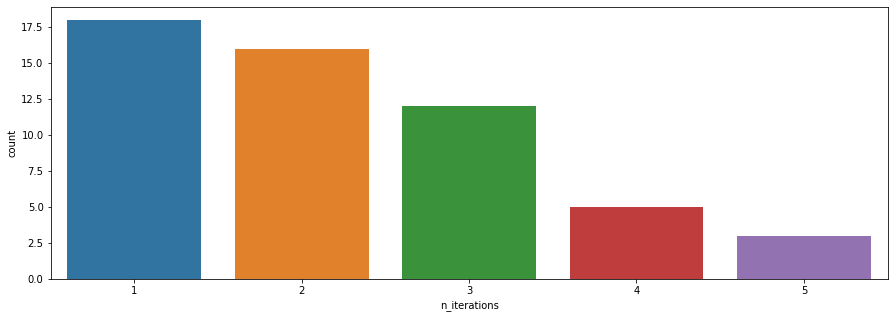

In [162]:
sns.countplot(tags_pairs_iterations.n_iterations)

In [108]:
tags_pairs_iterations = pd.DataFrame(iteration_data, columns=["from_tag", "to_tag", "n_iterations"])
tags_pairs_iterations

,from_tag,to_tag,n_iterations
0,4.5.6,4.5.7,1
1,5.1,5.1.1,1
2,5.1.1,5.1.2,2
3,5.1.2,5.2,3
4,5.2,5.3,3
5,5.3,5.4,3
6,5.4,5.5,3
7,5.5,5.6,3
8,5.6,5.6.1,2
9,5.6.1,5.6.2,2


In [109]:
tags_pairs_prs = pd.DataFrame(prs_data, columns=["from_tag", "to_tag", "pr_number"])
tags_pairs_prs.head()

,from_tag,to_tag,pr_number
0,5.1.1,5.1.2,403
1,5.1.1,5.1.2,425
2,5.1.1,5.1.2,403
3,5.1.1,5.1.2,425
4,5.1.2,5.2,475


In [222]:
tags_pairs_commits = pd.DataFrame(commit_data, columns=["from_tag", "to_tag", "commitsha"])
tags_pairs_commits.shape

(150140, 3)

In [152]:
tags_pairs_iterations.to_csv(f"{csv_folder}/tags_pairs/tags_pairs_iterations.csv")
tags_pairs_prs.to_csv(f"{csv_folder}/tags_pairs/tags_iterative_prs.csv")
tags_pairs_commits.to_csv(f"{csv_folder}/tags_pairs/tags_pairs_iterative_commits.csv")

In [223]:
len(jobs[~jobs.commitsha.isin(tags_pairs_commits.commitsha)])/len(jobs)

0.15279998247957777

**Investigate included PRs**

Should we exclude the not merged ones?

In [119]:
prs_included = prs[prs.pr_number.isin(tags_pairs_prs.pr_number)]
prs_included[~prs_included.merged]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
51,657,SONAR-6892 WS permissions/search_project_permi...,2015-11-27 17:10:58+00:00,2015-11-30 13:09:52+00:00,closed,False,93a72c9e801ca444de4a35cded36371a75d8d35f,0a8a13500a85c8454b30390e236c7588351c88f4,master,0a8a13500a85c8454b30390e236c7588351c88f4,feature/ws_filter_by_qualifier
59,680,SONAR-6900 Keep quality gate details on succes...,2015-12-04 11:14:43+00:00,2015-12-07 23:28:36+00:00,closed,False,1a3708f2407eae0961f6196d472e59a00d872af3,0a5e742023c7ee832c2b52de93e1c27cf76c34f4,master,0a5e742023c7ee832c2b52de93e1c27cf76c34f4,feature/tb/ce-task-details
65,684,SONAR-6820 WS has page size limit of 500,2015-12-07 15:15:56+00:00,2015-12-07 17:10:57+00:00,closed,False,9a4bd49b0f27ee5c055a55f573b459973eed4bb8,c6374cf5b6820acd23b5a172b94cc56e90614e2d,master,c6374cf5b6820acd23b5a172b94cc56e90614e2d,feature/tb/limit-page-size-in-ws
67,654,WS user_tokens/revoke and WS user_tokens/search,2015-11-26 07:42:04+00:00,2015-11-26 13:19:34+00:00,closed,False,e3f1420b046ade80000c6cb1bb3749abdc5fcafe,3a1d39423a5d340cfdd7a4cb1b2dfa6a5a70447a,master,3a1d39423a5d340cfdd7a4cb1b2dfa6a5a70447a,feature/ws_list_tokens
90,662,SONAR-7034 WS ce/task works for users with the...,2015-12-01 09:39:21+00:00,2015-12-02 09:49:26+00:00,closed,False,cc5fa0dae684f60bc7cf6c9d93d92be37b7bbc9a,83e47cf30c12fe6aa02ea14669f139e6530b48fb,master,83e47cf30c12fe6aa02ea14669f139e6530b48fb,feature/tb/task-ws-with-scan-perm
94,694,SONAR-7137 Fix migration that remove duplicate...,2015-12-15 11:10:31+00:00,2015-12-15 11:10:49+00:00,closed,False,42b38e6f04fdc81b73034ca1ba47588bb37481a4,c5794e1e2faa062a97df6663fdd4918382e6b0c6,master,dfcd64dac0c3bec67eb0c9939191fa7831b59c3b,feature/jl/fix_components_duplication_deletion
97,661,SONAR-7084 Analysis do not fail when a compone...,2015-11-30 15:52:28+00:00,2015-12-02 09:46:40+00:00,closed,False,1fe854cb464116919ef3ef7a35e7c54b5fc2fde9,f463897daea037addd0ee5d1a45c046b784e1fc5,master,f463897daea037addd0ee5d1a45c046b784e1fc5,feature/tb/fix-protobuf-exception
100,955,SONAR-7628 WS api/qualitygates/project_status ...,2016-05-11 14:13:11+00:00,2016-05-12 12:36:35+00:00,closed,False,b6fc139449fa91ce68708bf98c1a684929634406,4c56e6c287c0ca07dba287a234759c5a32193ba7,master,4c56e6c287c0ca07dba287a234759c5a32193ba7,feature/tb/project_status_browse_permission
107,961,SONAR-7545 functional error when updating a pr...,2016-05-12 12:24:43+00:00,2016-05-13 08:06:53+00:00,closed,False,88b5d5f4307eb05a8dafb0a13adb0657dfd0906f,27aa656e1f6031e54f004c9f91d7919f3cb79722,master,27aa656e1f6031e54f004c9f91d7919f3cb79722,feature/tb/update_key_with_functional_errors
126,976,SONAR-7635 WS returns english localization of ...,2016-05-13 16:40:57+00:00,2016-05-18 09:50:07+00:00,closed,False,6f7f2ee9e13faa43e6e52a74e02cc9b051d364f0,3e08e0769b8fa6ac333fd66d16f8c48dc281103a,master,3e08e0769b8fa6ac333fd66d16f8c48dc281103a,feature/tb/7635_metric_name_localized


**Investigate not included PRs**

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='merged', ylabel='count'>

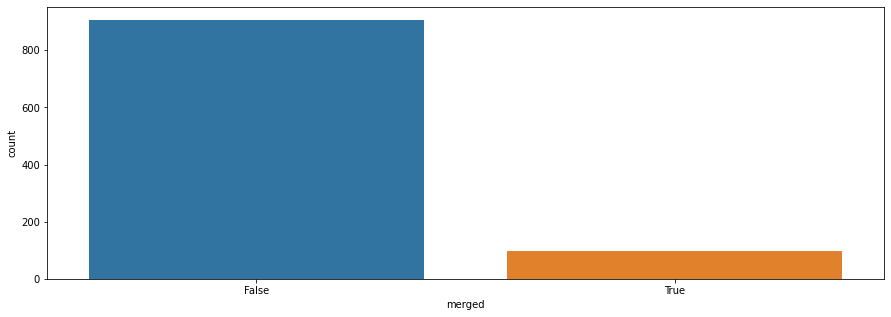

In [120]:
sns.countplot(prs[~prs.pr_number.isin(tags_pairs_prs.pr_number)].merged)

They are mostly not merged PRs. What about the merged ones?

In [121]:
prs[(~prs.pr_number.isin(tags_pairs_prs.pr_number)) \
    & (prs.created_at > pd.to_datetime("2015-03-05 14:39:13+00:00")) & (prs.merged)]

,pr_number,title,created_at,closed_at,state,merged,merge_commit_sha,base_sha,base_ref,head_sha,head_ref
351,2606,SONAR-9882,2017-10-02 15:03:40+00:00,2017-10-03 13:39:09+00:00,closed,True,0f7be9c7a2e04aec945dcb9f399e0962de2c1ce0,665c76ed3ff786ec84d51a61a825a048668dd3f4,feature/atlas/MMF-988/webhook_call_on_issue_ch...,b3d62bc8f6a41f3c089f115f37ef5849694ed6f5,feature/eh/SONAR-9882
372,2634,SONAR-9871 call project webhook on issue chang...,2017-10-09 09:22:14+00:00,2017-10-09 15:19:28+00:00,closed,True,9158491cca6240b4c0bfa66a87d122275b1af707,327dfa90bc92133bf903cee0619104220b197351,feature/atlas/MMF-988/webhook_call_on_issue_ch...,9158491cca6240b4c0bfa66a87d122275b1af707,feature/sl/SONAR-9871/call_project_webhook_on_...
412,3157,SONAR-9338 Make all date pickers consistent,2018-03-15 16:24:39+00:00,2018-03-16 15:24:04+00:00,closed,True,fd7209384d5f2d7ba3e23f36e9b330bb8f5b4234,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e18524ff695bf0d4d90552258236da04dc2d06d9,feature/stas/datepicker
425,3151,Move VSTS extension to its own module,2018-03-13 16:51:22+00:00,2018-03-15 09:09:56+00:00,closed,True,360b53b020a193ff3c377779e0e69d2c5e91c75f,49c2d1701c09f9cca80c8fed6b0ef49327d5b0cc,feature/MMF-1123/vsts_integration,1dfe666aee64406626b563237349d2bf17f403cf,feature/greg/vsts_move_to_module
429,3152,Rewrite SelectList component in React on Quali...,2018-03-14 09:30:30+00:00,2018-03-16 15:21:30+00:00,closed,True,5b5b8896faa4f135c39ce894e7084a7e0a5f0f6f,9ee317bc4bf7de3cde6fad799d08e565630cc864,feature/full-react,e33fc12cd28cbd464977643483f1d251c2320686,feature/pm/rewriting-selectlist-in-react
584,291,feature/fix_mssql_role,2015-05-05 20:47:30+00:00,2015-05-06 21:00:22+00:00,closed,True,053bdad7ba27899fa5eab6a99cdd6b10e5e941b4,543e5a352f60add1eeef61ad3c4dba7ce826bdb6,branch-4.5,f0d72ab12bda27a060554042db2d09b3e672a823,feature/fix_mssql_role
708,1915,Create members group when creating org,2017-04-10 14:56:38+00:00,2017-04-11 14:27:36+00:00,closed,True,627c7e7b9298d947a3965724f18e8648a5b4379c,c769fb54f7167b56fd603304feedd12a84393bc2,feature/lambda/add_default_group_in_organizations,627c7e7b9298d947a3965724f18e8648a5b4379c,feature/jl/create_members_group_when_creating_org
738,1934,"SONAR-9115 let api/rules/create fail, if organ...",2017-04-13 15:27:27+00:00,2017-04-14 07:00:06+00:00,closed,True,7557e66df346d698cd9894cd6ea785732a68a624,a7d3c82fa1c316c312ff7dbb9502bc1a82fd7665,feature/daniel/MMF-838/make_rules_ws_organizat...,1615b82d592912d9f87ff1fbf918a1f721eb9c48,feature/daniel/MMF-838/SONAR-9115/fail_custom_...
778,2984,SONAR-10313 change route and key of issue to i...,2018-01-25 09:45:12+00:00,2018-02-05 16:24:05+00:00,closed,True,f20057b318d07fdfd72f041f0d300874d614339b,76f37d0564f865e87d558b0169ce8424bc9cafcc,feature/MMF-1153/support_rule_key_renaming,f20057b318d07fdfd72f041f0d300874d614339b,feature/sl/7.1/SONAR-10313/remove_key_from_rul...
1003,2324,SONAR-9616 batch/project should fail on unknow...,2017-08-04 08:46:44+00:00,2017-08-04 09:31:01+00:00,closed,True,1fde22402ffb9b2e5aa1bc7144d303891a3ed956,d1124ea12d2cd0bc7817a00ce360bd113b0e1e6e,feature/MMF-972/long-branches-rebased-on-incre...,c91063eea898c22767d85a9b3cc03adebdaa1f11,feature/jl/MMF-972/return_404_on_unknown_branc...


**Investigate not assigned jobs**

In [215]:
jout = jobs[~jobs.commitsha.isin(tags_pairs_commits.commitsha) & (jobs.commitmessage.str.startswith("SONAR-"))]
jout

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
212,181464352,181464351,2016-12-05 20:40:07+00:00,2016-12-05 20:39:59.230000+00:00,2016-12-05 20:54:13+00:00,15736.1,passed,2018-06-01 16:26:24.712000+00:00,9178026afd12c8cb45cd6b83af500c8b81de629a,51794052,SONAR-5471 drop data change migrations of 5.3,refs/heads/feature/sb/compress-ruby-migrations,https://github.com/SonarSource/sonarqube/compa...
213,181464359,181464351,2016-12-05 20:40:09+00:00,2016-12-05 20:40:00.155000+00:00,2016-12-05 20:41:38+00:00,15736.2,passed,2018-06-01 16:26:24.823000+00:00,9178026afd12c8cb45cd6b83af500c8b81de629a,51794052,SONAR-5471 drop data change migrations of 5.3,refs/heads/feature/sb/compress-ruby-migrations,https://github.com/SonarSource/sonarqube/compa...
214,181474725,181474724,2016-12-05 21:18:04+00:00,2016-12-05 21:18:02.083000+00:00,2016-12-05 21:21:44+00:00,15737.1,canceled,2018-06-01 16:26:48.359000+00:00,1279b39395b2fe182fceaa5fa5e45f2a683b5cbe,51797140,SONAR-5471 remove data change migrations of 5.4,refs/heads/feature/sb/compress-ruby-migrations,https://github.com/SonarSource/sonarqube/compa...
215,181474726,181474724,2016-12-05 21:18:03+00:00,2016-12-05 21:18:02.107000+00:00,2016-12-05 21:19:36+00:00,15737.2,passed,2018-06-01 16:26:48.370000+00:00,1279b39395b2fe182fceaa5fa5e45f2a683b5cbe,51797140,SONAR-5471 remove data change migrations of 5.4,refs/heads/feature/sb/compress-ruby-migrations,https://github.com/SonarSource/sonarqube/compa...
216,181475285,181475284,2016-12-05 21:20:08+00:00,2016-12-05 21:20:04.122000+00:00,2016-12-05 21:35:46+00:00,15738.1,passed,2018-06-01 16:26:32.560000+00:00,71111ebad9da23121505eb3c46f4899ded562839,51797293,SONAR-5471 remove data change migrations of 5.4,refs/pull/1433/merge,https://github.com/SonarSource/sonarqube/pull/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136966,315384398,315384395,2017-12-12 14:26:19+00:00,2017-12-12 14:25:30.478000+00:00,2017-12-12 14:29:36+00:00,34805.2,passed,2018-06-03 16:57:05.916000+00:00,9521be1f628b8a6c7275fbcf2275bc7aa84b99d0,93633590,SONAR-10117 add test on error handling in Live...,refs/pull/2901/merge,https://github.com/SonarSource/sonarqube/pull/...
136979,315421139,315421138,2017-12-12 15:43:05+00:00,2017-12-12 15:42:34.642000+00:00,2017-12-12 15:44:59+00:00,34812.1,passed,2018-06-03 16:57:47.762000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136980,315421140,315421138,2017-12-12 15:43:26+00:00,2017-12-12 15:42:34.682000+00:00,2017-12-12 15:44:25+00:00,34812.2,passed,2018-06-03 16:57:47.778000+00:00,04d5e19040df59e2a4a1025514c9b8b7c42378f8,93645831,SONAR-10187 Provide more options to populate e...,refs/heads/feature/stas/MMF-1128,https://github.com/SonarSource/sonarqube/compa...
136981,315421147,315421146,2017-12-12 15:43:25+00:00,2017-12-12 15:42:40.583000+00:00,2017-12-12 16:01:05+00:00,34813.1,passed,2018-06-03 16:57:47.837000+00:00,a5005e0ca38a67e7d70c255154990ed10be31020,93645838,SONAR-10187 Provide more options to populate e...,refs/pull/2895/merge,https://github.com/SonarSource/sonarqube/pull/...


In [188]:
tags_pairs_prs

,from_tag,to_tag,pr_number
0,5.1.1,5.1.2,403
1,5.1.1,5.1.2,425
2,5.1.1,5.1.2,403
3,5.1.1,5.1.2,425
4,5.1.2,5.2,475
...,...,...,...
32054,7.6,7.7,639
32055,7.9,8.0,3227
32056,7.9,8.0,3227
32057,7.9.3,7.9.4,3245


Use fix version and commitmessage to assign builds to versions

In [123]:
fix_versions=issues[["issue_id", "issue_key"]].merge(fix_versions, on="issue_id")

In [124]:
fix_job_data = []
for i, row in fix_versions.iterrows():
    for j, row2 in jout[(jout.commitmessage.str.startswith(row.issue_key))].iterrows():
        fix_job_data.append((row.fixVersion_name, row2.commitsha))

In [125]:
tags_fix_commits = pd.DataFrame(fix_job_data, columns=["to_tag", "commitsha"]).drop_duplicates(keep="first")
tags_fix_commits

,to_tag,commitsha
0,8.5,2545e06845915284dfcacc23ed857a5f0cc2e5ab
2,8.5,6dc2cc9ff6340e6588b7608ed90354aa6767fcdf
4,8.5,88e87020615f59ceed877b2fce817689613dcd5d
6,8.5,17f30a2dff4ae0c087ccdcbb834b7b873b4a5f17
8,8.5,863d8a11ad8dcc3bdeedf13539e3aca9d4b45ad3
...,...,...
14166,5.3,7b97c6aa281d4fd9f2ecaf535ae6c2cfbb27008b
14176,5.3,0bdf459d2cd5bd796b75dcb0a45a9e9457436b10
14186,5.3,3e620b604242765f66bca0cf6746509985ef72b7
14196,5.3,2f722a9ff0f56c45752008bbb36bacf2d7b2b6a4


In [126]:
assigned_commits = set(tags_fix_commits.commitsha).union(set(tags_pairs_commits.commitsha))

In [127]:
len(jobs[~jobs.commitsha.isin(assigned_commits)])/len(jobs)

0.16604980180022338

In [145]:
#Replace git tag with jira versions so that it matches the format of the other datasets
tmp = tags_comparison.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
.drop(columns=["to_tag"]).rename(columns={"jira_version":"to_tag"})
tmp = tmp.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
.drop(columns=["from_tag"]).rename(columns={"jira_version":"from_tag"})
tags_fix_commits = tmp[["from_tag","to_tag"]].merge(tags_fix_commits, on="to_tag")
tags_fix_commits

,from_tag,to_tag,commitsha
0,5.1,5.1.1,cb80136ec83396ff030878aee53816de34565dd0
1,5.1,5.1.1,38e6025e76bf9446ae3ba87301b08691023b152c
2,5.1.2,5.2,20f87c2bece6bd1b00075ddf442c95cd9495f4d7
3,5.1.2,5.2,aa80cefeec72496c804b50bd2ef5d73e2423c6b2
4,5.1.2,5.2,baf9c1adfaf90fccfde8857ac140afdf997f8c65
...,...,...,...
3242,7.9,7.9.1,7900ef38cf88270dff106ec085ce0d862ef5abc4
3243,8.4,8.4.1,446a27fd0bb4c449db017760dc11ec92da35cb3c
3244,8.4,8.4.1,3adb1969a53fb22066453c36fe9d0acb6902d343
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40


In [146]:
tags_fix_commits.isna().sum()

from_tag     0
to_tag       0
commitsha    0
dtype: int64

In [153]:
tags_fix_commits.to_csv(f"{csv_folder}/tags_pairs/tags_fix_commits.csv")

### Merge all retrieved commits

In [217]:
all_commits_for_pairs = tags_pairs_commits.append(tags_fix_commits)
all_commits_for_pairs

,from_tag,to_tag,commitsha
0,4.5.6,4.5.7,e8d7e7b8c69be29869d200722e04ae85f6a6a2c0
1,4.5.6,4.5.7,8cd20603bdbff2d725a3ba981839120b8d40faac
2,4.5.6,4.5.7,36d9a7959a95cbe44550e2c7790bf68d4c1066c8
3,4.5.6,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83
4,4.5.6,4.5.7,b2a6182d3f40e316e242dc15529008f7b84cdde2
...,...,...,...
3242,7.9,7.9.1,7900ef38cf88270dff106ec085ce0d862ef5abc4
3243,8.4,8.4.1,446a27fd0bb4c449db017760dc11ec92da35cb3c
3244,8.4,8.4.1,3adb1969a53fb22066453c36fe9d0acb6902d343
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40


### Validate our assignment using fixversion
Validating would be nice but our approach does not always match what is reported in fix versions

Info on Jira may be partial and we detect more than just the first version in which a fix is introduced

In [575]:
x = tags_pairs_commits.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")
x = x.merge(jobs[["commitsha", "commitmessage"]], on="commitsha")
y = x[x.commitmessage.fillna("").str.startswith("SONAR-")]
y["issue_key"] = y.commitmessage.apply(lambda x: x.split(" ")[0])
fix_versions_list = fix_versions.groupby("issue_key").fixVersion_name.apply(list).reset_index()
y = y.merge(fix_versions_list, on="issue_key")

<ipython-input-575-ff9e705b64ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["issue_key"] = y.commitmessage.apply(lambda x: x.split(" ")[0])


In [578]:
match = y[y.apply(lambda row: row.jira_version in row.fixVersion_name, axis=1)]
not_match = y[y.apply(lambda row: not row.jira_version in row.fixVersion_name, axis=1)]

In [583]:
print(len(match))
match.issue_key.nunique()

54480


2052

In [584]:
print(len(not_match))
not_match.issue_key.nunique()

207175


1839

In [585]:
not_match

,from_tag,to_tag,commitsha,Tag,jira_version,commitmessage,issue_key,fixVersion_name
9,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,6.1,6.1,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
10,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,6.1,6.1,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
11,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,6.1,6.1,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
12,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,6.1,6.1,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
13,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,6.1,6.1,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
...,...,...,...,...,...,...,...,...
261504,7.9.3,7.9.4,4210d6ebd2d2b54f3e98ceb9a324ef7a163bf99a,7.9.4,7.9.4,SONAR-13618 Remove new lines from db migration...,SONAR-13618,[8.5]
261509,7.9.3,7.9.4,281f480cfd65d85ebb27da9e77f15dbf71cb7f54,7.9.4,7.9.4,SONAR-13259 Fix branch analysis on Travis CI f...,SONAR-13259,[8.3]
261510,7.9.3,7.9.4,281f480cfd65d85ebb27da9e77f15dbf71cb7f54,7.9.4,7.9.4,SONAR-13259 Fix branch analysis on Travis CI f...,SONAR-13259,[8.3]
261525,8.1.0.31237,8.2.0.32929,957309d4fc508e637e04558abc56ad9bbfb9b73b,8.2.0.32929,8.2,SONAR-12849 Upgrade sonar-cfamily to 6.5,SONAR-12849,[8.1]


In [581]:
y.issue_key.nunique()

2102

In [ ]:
fx = fix_versions_list[fix_versions_list.issue_key.isin(\
                set(not_match.issue_key.unique()).difference(set(match.issue_key.unique())))]
fx

In [546]:
not_match

,from_tag,to_tag,commitsha,commitmessage,issue_key,fixVersion_name
9,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
10,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
11,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
12,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
13,6.0,6.1,40b5428c8335810b339a7cd1fe80404c9e64547b,SONAR-6854 use api/user_groups,SONAR-6854,[5.2]
...,...,...,...,...,...,...
261650,8.3.0.34182,8.4.0.35506,ae779528b341900152976ceefbef862ce715dbe6,SONAR-12911 Code viewer is not accessible to b...,SONAR-12911,[8.4]
261651,8.3.0.34182,8.4.0.35506,4fc4a5853354a00e80f1e27556385e4338b57cd0,SONAR-13447 Update the Upgrade Notes with depr...,SONAR-13447,[8.4]
261652,8.3.0.34182,8.4.0.35506,4fc4a5853354a00e80f1e27556385e4338b57cd0,SONAR-13447 Update the Upgrade Notes with depr...,SONAR-13447,[8.4]
261653,8.3.0.34182,8.4.0.35506,947685909fbdee4146a59c67cc706b5e7f530876,SONAR-12920 Add product footer to the Hotspots...,SONAR-12920,[8.4]


In [ ]:
count_match = 0
for i, row in fx.iterrows():
    commits = git.log("--all", "--oneline", f"--grep={row.issue_key}").split("\n")
    for commit in commits:
        sha = commit.split(" ")[0]
        tags = git.tag("--contains", sha).split("\n")
        for tag in tags:
            if(tag in row.fixVersion_name):
                count_match+=1
                print(row.issue_key, tag)
                continue

In [534]:
count_match

56

In [535]:
len(fx)

109

In [539]:
y[y.issue_key == "SONAR-9882"]

,from_tag,to_tag,commitsha,commitmessage,issue_key,fixVersion_name
261451,7.9,8.0,2ad2359c06b32be3ea7eeacc9e40fd7cc60efc42,SONAR-9882 column should be named ANALYSIS_PRO...,SONAR-9882,[6.7]
261452,7.9,8.0,2ad2359c06b32be3ea7eeacc9e40fd7cc60efc42,SONAR-9882 column should be named ANALYSIS_PRO...,SONAR-9882,[6.7]
